In [1]:
import random
import torch


words = open('words.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness, sorted for reproducibility
max_len = max(len(w) for w in words)
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.']))) # add special token
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
vocab_size = len(chs)
block_size = max_len + 1
X, Y = [], []

for w in words:
    x = torch.zeros(max_len + 1, dtype=torch.long)
    y = torch.zeros(max_len + 1, dtype=torch.long)
    x[1:1+len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[:len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[len(w)+1:] = -1 # mask the loss at the inactive locations
    X.append(x)
    Y.append(y)

X = torch.stack(X)
Y = torch.stack(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

# split data into train, validation, and test
X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

show = 20
for x, y in zip(X_train[:show], Y_train[:show]):
    sx = ''.join(itos[i.item()] for i in x)
    sy = ''.join(itos[i.item()] for i in y if i.item() != -1)
    print(f'{sx} -> {sy}')

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


.exodus............ -> exodus.
.omened............ -> omened.
.sugars............ -> sugars.
.wide.............. -> wide.
.plugged........... -> plugged.
.bounds............ -> bounds.
.uman.............. -> uman.
.authoritarian..... -> authoritarian.
.benedicta......... -> benedicta.
.stepsister........ -> stepsister.
.neatest........... -> neatest.
.dreaming.......... -> dreaming.
.ceremoniously..... -> ceremoniously.
.harder............ -> harder.
.misunderstandings. -> misunderstandings.
.governed.......... -> governed.
.scarped........... -> scarped.
.goodish........... -> goodish.
.closer............ -> closer.
.countersign....... -> countersign.


(torch.Size([23367, 19]),
 torch.Size([2921, 19]),
 torch.Size([2921, 19]),
 torch.Size([23367, 19]),
 torch.Size([2921, 19]),
 torch.Size([2921, 19]))

In [2]:
from dataclasses import dataclass
from tiny_torch_nn import *


@dataclass
class ModelConfig:
    block_size: int = block_size # length of the input sequences of integers
    vocab_size: int = vocab_size # the input integers are in range [0 .. vocab_size -1]
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    dtype: torch.dtype = torch.float64
    
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None, generator=None):
    """
    Predict the next token in the sequence.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        # only select top k tokens
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = logits.softmax(dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1, generator=generator)
        else: # greedy sampling
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
        if idx_next.item() == 0:
            break
    return idx

def sample(models, generator=None):
    """
    Generate 10 samples from each model.
    """
    for _ in range(10):
        s_list = []
        for name, model in models.items():
            tks = generate(model, torch.tensor([[0]]), max_new_tokens=10, do_sample=True, generator=generator)[0].tolist()
            s = ''.join(itos[i] for i in tks)
            s_list.append(s)
        out = ' | '.join(f'{name}: {s:<13s}' for name, s in zip(models.keys(), s_list))
        print(f'{out}')


In [3]:
# set seed for reproducibility
torch.manual_seed(42)

# control the size of each model to be roughly the same
model_mlp = MLP(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=21))
model_rnn = RNN(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=45))
model_gru = GRU(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=27))
model_transformer = Transformer(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=15, n_head=1, n_layer=1))
models = {
    'mlp': model_mlp,
    'rnn': model_rnn,
    'gru': model_gru,
    'transformer': model_transformer
}

# initially, model generates random characters
g = torch.Generator().manual_seed(42)
sample(models, generator=g)


number of mlp parameters: 4031
number of rnn parameters: 3933
number of gru parameters: 3915
number of transformer parameters: 4020
mlp: .xjugueovtp   | rnn: .s.           | gru: .fabiquedxf   | transformer: .mubnwmsfla  
mlp: .ypglzofmwh   | rnn: .wgxoln.      | gru: .epjccuodsg   | transformer: .ldmzu.      
mlp: .knpcmjjobd   | rnn: .rggbdllk.    | gru: .mnqhqyjfbh   | transformer: .cvghigeacz  
mlp: .alcvjwiarw   | rnn: .tphjpdmqso   | gru: .tcc.         | transformer: .welqxouvgk  
mlp: .ohobr.       | rnn: .uklnncvrig   | gru: .mydysoumf.   | transformer: .pjjiewx.    
mlp: .lhmjuhm.     | rnn: .fsckbirdov   | gru: .hgn.         | transformer: .kgoktfkzua  
mlp: .cabpu.       | rnn: .atodr.       | gru: .bxwqljcdq.   | transformer: .tmdampezaq  
mlp: .j.           | rnn: .omtafjiirv   | gru: .qtlfkyeumx   | transformer: .uoftame.    
mlp: .evzqmyiog.   | rnn: .acdtqumkor   | gru: .vdyxxhlsog   | transformer: .ob.         
mlp: .tnslwkganf   | rnn: .uyccqendhl   | gru: .n.        

In [4]:
# all models use the same loss function
loss_fns = [CrossEntropyLoss3d() for _ in range(len(models))]
val_loss_fn = CrossEntropyLoss3d()
params = [p for model in models.values() for p in model.parameters()]

# args
n_steps = 20000
eval_every = 1000
bs = 32
ini_lr = 0.1

# train
lossi = []
for  step in range(n_steps):
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]
    lr = ini_lr if step < int(n_steps * 0.75) else ini_lr * 0.1

    losses = []
    for (name, model), loss_fn in zip(models.items(), loss_fns):
        logits = model(x)
        loss = loss_fn(logits, y)
        dlogits = loss_fn.backward(loss)
        model.backward(dlogits)
        losses.append(loss)
    lossi.append(losses)
    grads = [g for model in models.values() for g in model.grads() ]
    for p, g in zip(params, grads):
        p.data -= lr * g
    
    if step % eval_every == 0 or step == n_steps - 1:
        x, y = X_val, Y_val
        val_losses = []
        for name, model in models.items():
            logits = model(x)
            val_loss = val_loss_fn(logits, y, ignore_index=-1)
            val_losses.append(val_loss)
        loss_out = f' | '.join(f'{name}: {loss.item():.4f}' for name, loss in zip(models.keys(), losses))
        val_loss_out = f' | '.join(f'{name}: {val_loss.item():.4f}' for name, val_loss in zip(models.keys(), val_losses))
        print(f'step {step+1:<4} || Train || {loss_out} || Val || {val_loss_out}')




step 1    || Train || mlp: 3.2874 | rnn: 3.2959 | gru: 3.2958 | transformer: 3.2950 || Val || mlp: 3.2455 | rnn: 3.2788 | gru: 3.2841 | transformer: 3.2658
step 1001 || Train || mlp: 2.4054 | rnn: 2.3167 | gru: 2.4342 | transformer: 2.4162 || Val || mlp: 2.3930 | rnn: 2.3307 | gru: 2.4312 | transformer: 2.3980
step 2001 || Train || mlp: 2.1985 | rnn: 2.1319 | gru: 2.2070 | transformer: 2.2358 || Val || mlp: 2.3175 | rnn: 2.2503 | gru: 2.3363 | transformer: 2.3385
step 3001 || Train || mlp: 2.3351 | rnn: 2.2675 | gru: 2.3345 | transformer: 2.3980 || Val || mlp: 2.2844 | rnn: 2.2069 | gru: 2.2846 | transformer: 2.3068
step 4001 || Train || mlp: 2.3450 | rnn: 2.2243 | gru: 2.3120 | transformer: 2.3912 || Val || mlp: 2.2676 | rnn: 2.1836 | gru: 2.2513 | transformer: 2.2747
step 5001 || Train || mlp: 2.4563 | rnn: 2.4007 | gru: 2.4284 | transformer: 2.4311 || Val || mlp: 2.2578 | rnn: 2.1735 | gru: 2.2315 | transformer: 2.2612
step 6001 || Train || mlp: 2.2316 | rnn: 2.2342 | gru: 2.2448 | 

In [7]:
x, y = X_test, Y_test
test_losses = []
for name, model in models.items():
    logits = model(x)
    test_loss = val_loss_fn(logits, y, ignore_index=-1)
    test_losses.append(test_loss)
test_loss_out = f' | '.join(f'{name}: {test_loss.item():.4f}' for name, test_loss in zip(models.keys(), test_losses))
print(f'test || {test_loss_out}')

print()

# after training, the model generates words that are more similar to English
g = torch.Generator().manual_seed(42)
sample(models, generator=g)


test || mlp: 2.1986 | rnn: 2.1012 | gru: 2.1249 | transformer: 2.1631

mlp: .couged.      | rnn: .vige.        | gru: .fabidushen   | transformer: .mustarsila  
mlp: .inglaked.    | rnn: .holinan.     | gru: .eppack.      | transformer: .deglessi.   
mlp: .bepch.       | rnn: .bording.     | gru: .decormord.   | transformer: .trabs.      
mlp: .vesines.     | rnn: .salcritian   | gru: .clusts.      | transformer: .mastect.    
mlp: .sentroudg.   | rnn: .stoor.       | gru: .uranners.    | transformer: .shinest.    
mlp: .stip.        | rnn: .siewo.       | gru: .limjumm.     | transformer: .friveradin  
mlp: .hon.         | rnn: .brows.       | gru: .cluscabla.   | transformer: .atorret.    
mlp: .relicd.      | rnn: .vamdampera   | gru: .bunged.      | transformer: .frilts.     
mlp: .tlacked.     | rnn: .rucktere.    | gru: .ensquiror.   | transformer: .aching.     
mlp: .horiesterl   | rnn: .sogom.       | gru: .thurked.     | transformer: .incasceend  


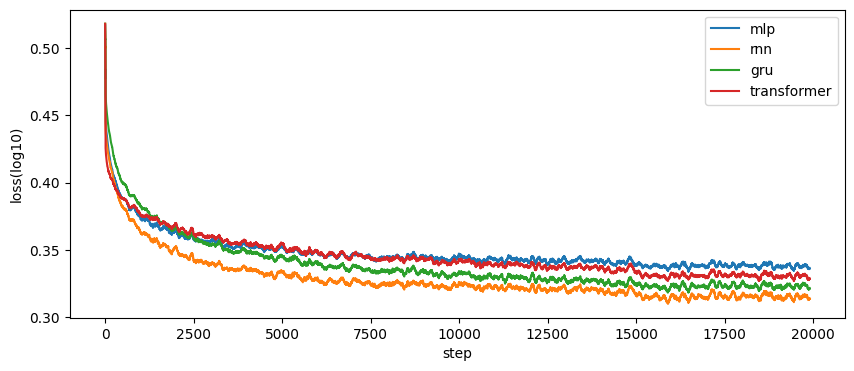

In [8]:
import matplotlib.pyplot as plt

def avg_loss(losses, window=100):
    ini_loss = losses[:10]
    avg_loss = losses[10:].unfold(0, window, 1).mean(1)
    return torch.cat([ini_loss, avg_loss]) # first 10 steps are not averaged, otherwise the initial loss is different

lossi = torch.tensor(lossi) if not isinstance(lossi, torch.Tensor) else lossi
log_lossi = lossi.log10()
model_names = list(models.keys())

plt.figure(figsize=(10, 4))
for i in range(log_lossi.shape[1]):
    plt.plot(avg_loss(log_lossi[:, i]), label=f'{model_names[i]}')
plt.xlabel('step')
plt.ylabel('loss(log10)')
plt.legend()
plt.show()



